In [12]:
%load_ext autoreload
%autoreload 2

import pathlib
from datetime import timedelta
from typing import List, Dict
import random

import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
sns.set_palette(sns.color_palette(colors))

from data_handlers.runtimes import *
from data_handlers.preprocessors import node_types

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
experiment_path = pathlib.Path(f"/storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/6/")

color_mapping = {
    'Epidemic': 'C0',
    'Software Defined Complex': 'C1',
}

groups = [
    ["Epidemic", "Software Defined Complex"]
]

order = ["Epidemic", 'Software Defined Complex']

In [3]:
def progress_bar(current, maximum):
    executed_percent = int(round((current / maximum) * 100))
    print(f"\r[", end="")
    print(f"#" * executed_percent, end="")
    print(f"_" * (100 - executed_percent), end="")
    print(f"]", end="")
    
    if executed_percent == 100:
        print(f" Done", end="")
    else:
        print(f" {executed_percent}%", end="")

# Parse Experiments

In [10]:
raw_events = parse_bundle_events(experiment_path)

Parsing /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/6/ids/10
Parsing /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/6/ids/28
Parsing /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/6/ids/55
Parsing /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/6/ids/22
Parsing /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/6/ids/46
Parsing /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/6/ids/31
Parsing /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/6/ids/36
Parsing /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/6/ids/41
Parsing /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/6/ids/58
Parsing /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/6/ids/25
Parsing /storage/res

In [13]:
types = node_types(scenario_path="/storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/scenarios/responders/responders.xml")
type_frame = pd.DataFrame(types.items(), columns=["node", "node_type"])

In [14]:
merged_df = raw_events.merge(type_frame, how="left", on="node")

In [15]:
# REPLACE NAMES
# SHOULD BE MOVED TO PARSING!
merged_df.loc[merged_df['routing'] == 'epidemic', 'routing'] = 'Epidemic'
merged_df.loc[merged_df['routing'] == 'context_complex', 'routing'] = 'Software Defined Complex'

In [20]:
# FILL ALL NAs WITH THE ACTUAL SIZE OF THE BUNDLE.
# SHOULE BE MOVED TO PARSING AFTERWARDS!
event_frame = merged_df
event_frame["bundle_size"] = event_frame.groupby("bundle")["bundle_size"].transform(lambda x: x.fillna(x.mean()))

In [21]:
# SET SOME RANDOM SIZE FOR META DATA BUNDLES.
# SHOULD BE REPLACED WITH ACTUALL VALUES IN PARSING AS SOON AS AVAILABLE!
event_frame['bundle_size'] = event_frame['bundle_size'].mask(event_frame['bundle_size'].isna(), np.random.uniform(100, 1000, size=len(event_frame)))

In [22]:
event_frame.head()

,routing,sim_instance_id,payload_size,bundles_per_node,timestamp,event,node,bundle,bundle_size,meta,node_type
0,Epidemic,9,1000,10,2022-02-04 13:16:38.973122,creation,n21,dtn://n21/-697295798972-0,1000.0,False,civilian
1,Epidemic,9,1000,10,2022-02-04 13:16:38.983517,sending,n21,dtn://n21/-697295798972-0,1000.0,False,civilian
2,Epidemic,9,1000,10,2022-02-04 13:16:38.983518,sending,n21,dtn://n21/-697295798972-0,1000.0,False,civilian
3,Epidemic,9,1000,10,2022-02-04 13:16:38.983558,sending,n21,dtn://n21/-697295798972-0,1000.0,False,civilian
4,Epidemic,9,1000,10,2022-02-04 13:16:38.983561,sending,n21,dtn://n21/-697295798972-0,1000.0,False,civilian


## Run statistics

# Compute and plot Total Number of Forwards

In [23]:
def bundle_distribution(event_frame: pd.DataFrame) -> DataFrame:
    simulation_data = event_frame.set_index("timestamp")
    instances = simulation_data[simulation_data.event == "reception"].groupby(["sim_instance_id", "meta"])
    runtimes = []
    
    big_fat_dataframe = DataFrame()
    for _, instance in instances:
        if instance["meta"][0] == True:
            continue

        simulation_start = instance.index[0]
        instance["since_start"] = instance.index - simulation_start
        instance = instance.set_index("since_start")
        new_bundles = instance.groupby(pd.Grouper(freq='1Min')).apply(len).to_frame()
        new_bundles = new_bundles.rename(columns={0: "reception_count"})
        
        #while len(new_bundles) <= 15:
        #    new_bundles = new_bundles.append({"reception_count": 0}, ignore_index=True)
        
        new_bundles["sim_instance_id"] = instance["sim_instance_id"][0]
        new_bundles["routing"] = instance["routing"][0]
        new_bundles["bundles_per_node"] = instance["bundles_per_node"][0]
        new_bundles["reception_accumulated"] = new_bundles["reception_count"].cumsum()
        
        big_fat_dataframe = big_fat_dataframe.append(new_bundles)
        
    return big_fat_dataframe

In [26]:
distribution_df = bundle_distribution(event_frame)

In [37]:
distribution_df[distribution_df['routing'] == "Epidemic"]

,reception_count,sim_instance_id,routing,bundles_per_node,reception_accumulated
0 days 00:00:00,1167,39,Epidemic,50,1167
0 days 00:01:00,1223,39,Epidemic,50,2390
0 days 00:02:00,1042,39,Epidemic,50,3432
0 days 00:03:00,1334,39,Epidemic,50,4766
0 days 00:04:00,853,39,Epidemic,50,5619
0 days 00:05:00,1204,39,Epidemic,50,6823
0 days 00:06:00,1172,39,Epidemic,50,7995
0 days 00:07:00,1014,39,Epidemic,50,9009
0 days 00:08:00,894,39,Epidemic,50,9903
0 days 00:09:00,1619,39,Epidemic,50,11522


<ipython-input-39-c0e3cb409a1d>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(17, 10))


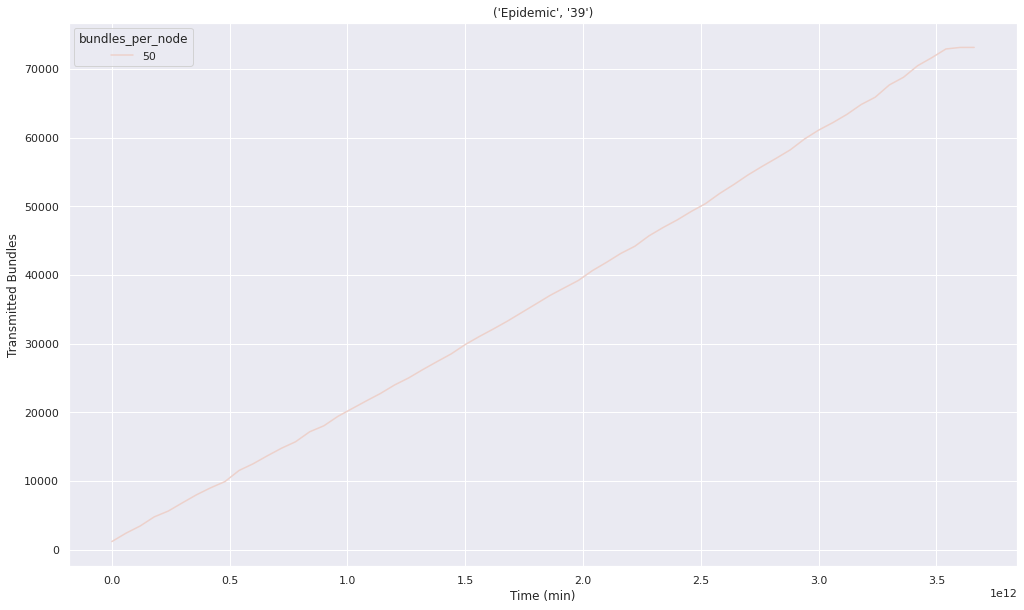

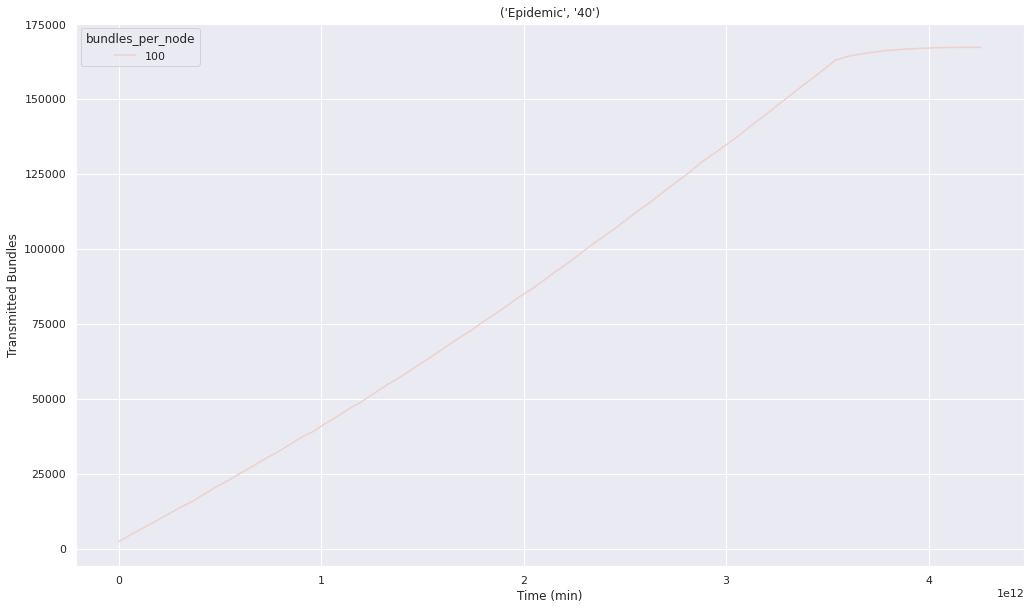

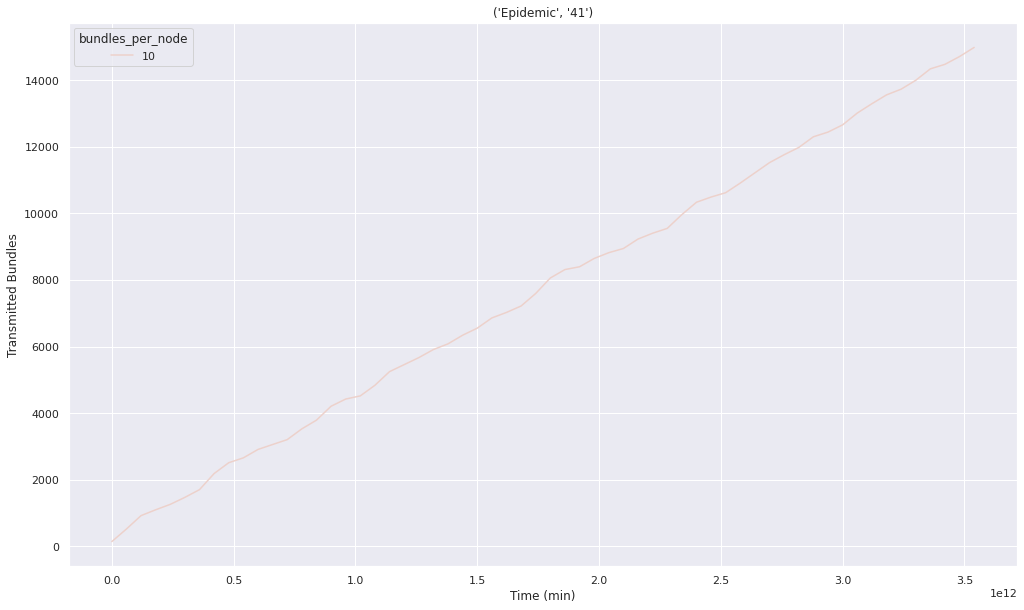

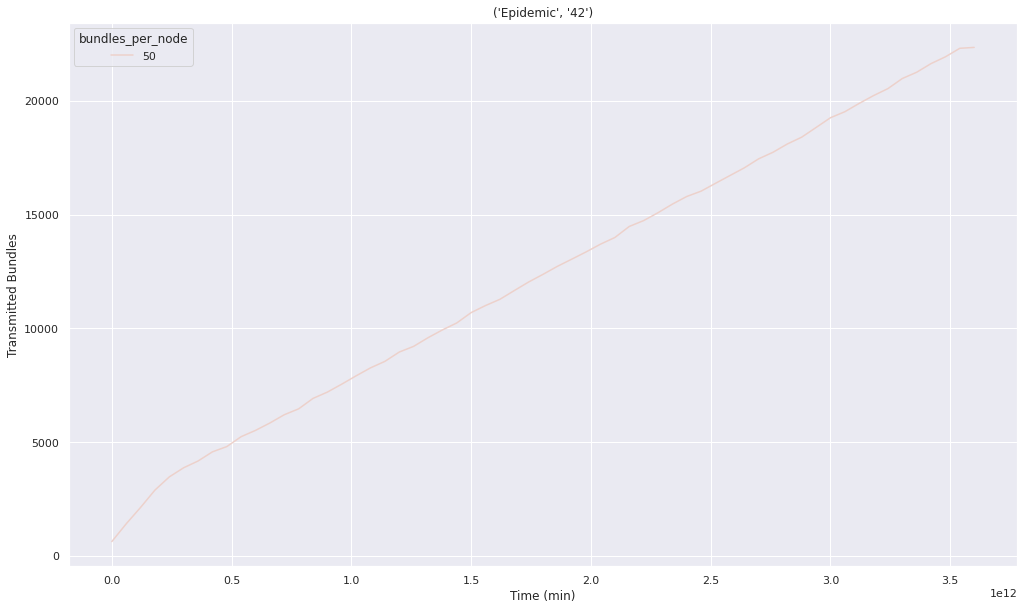

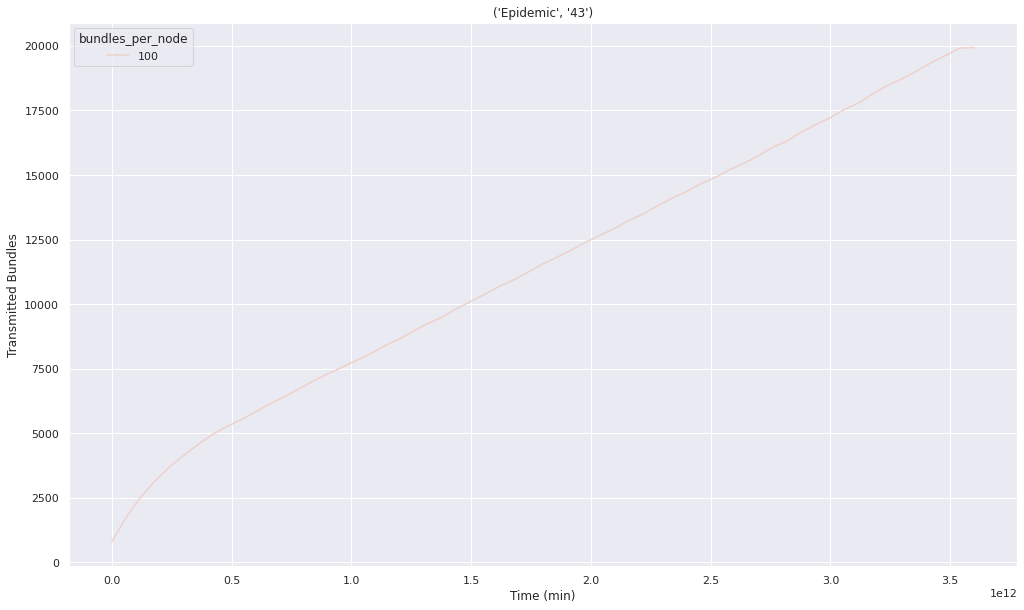

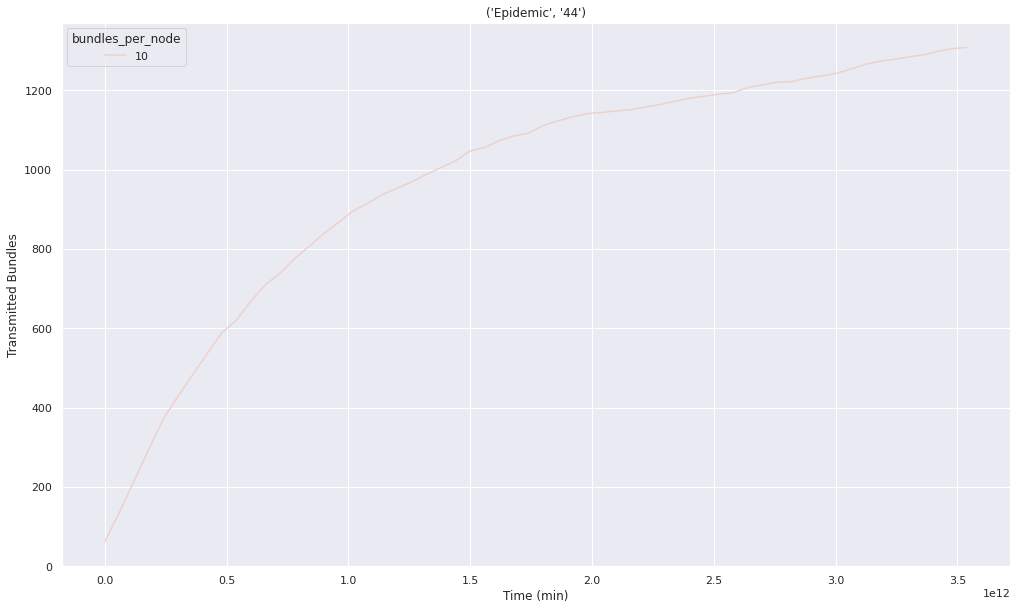

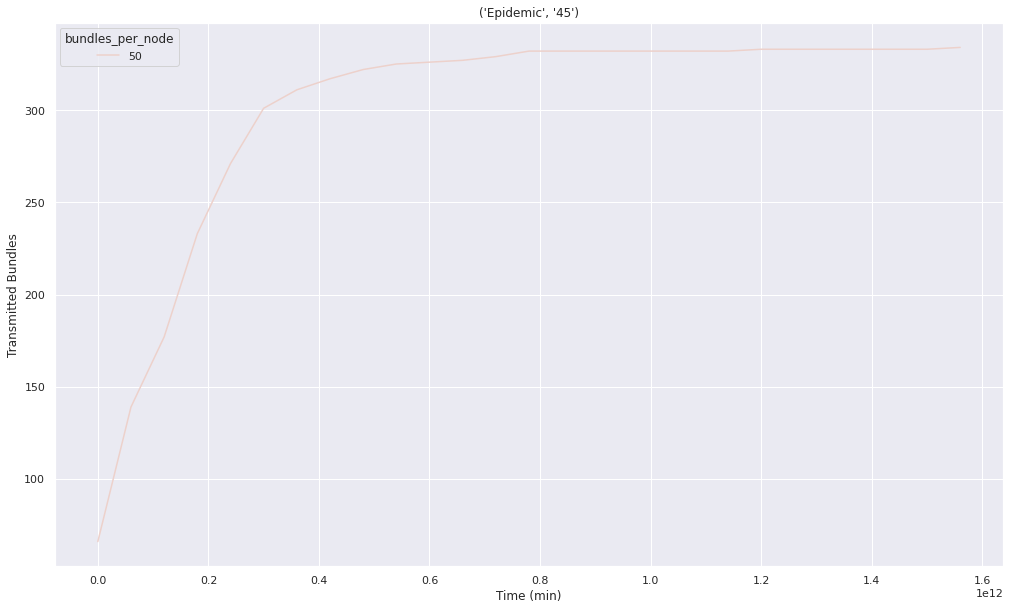

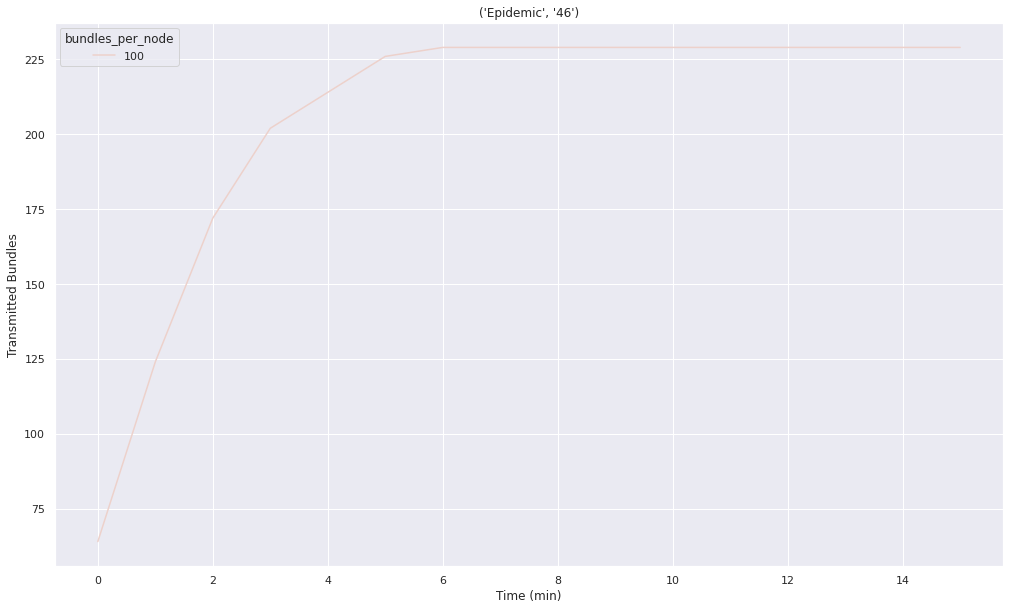

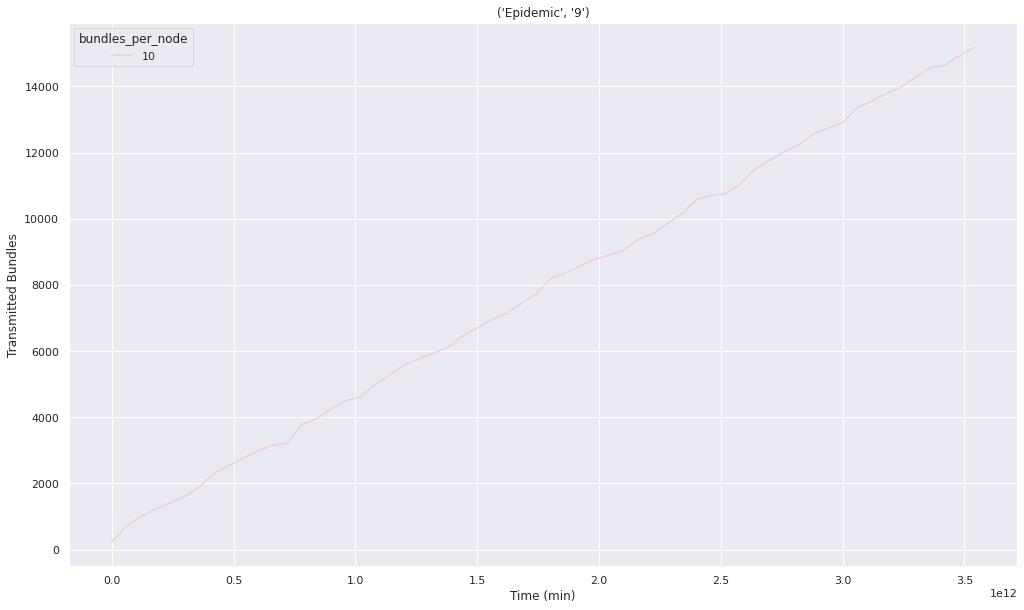

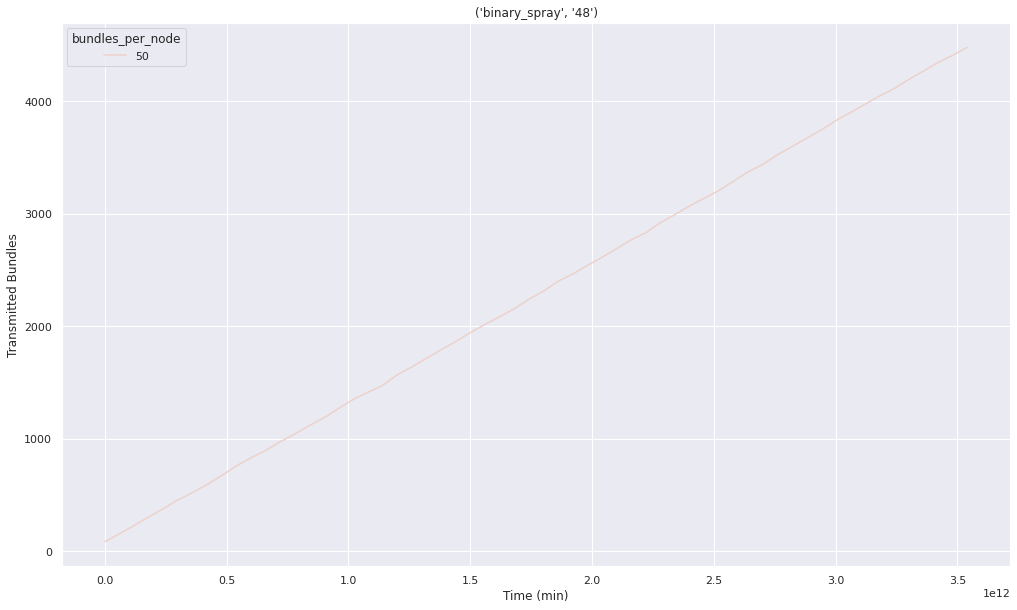

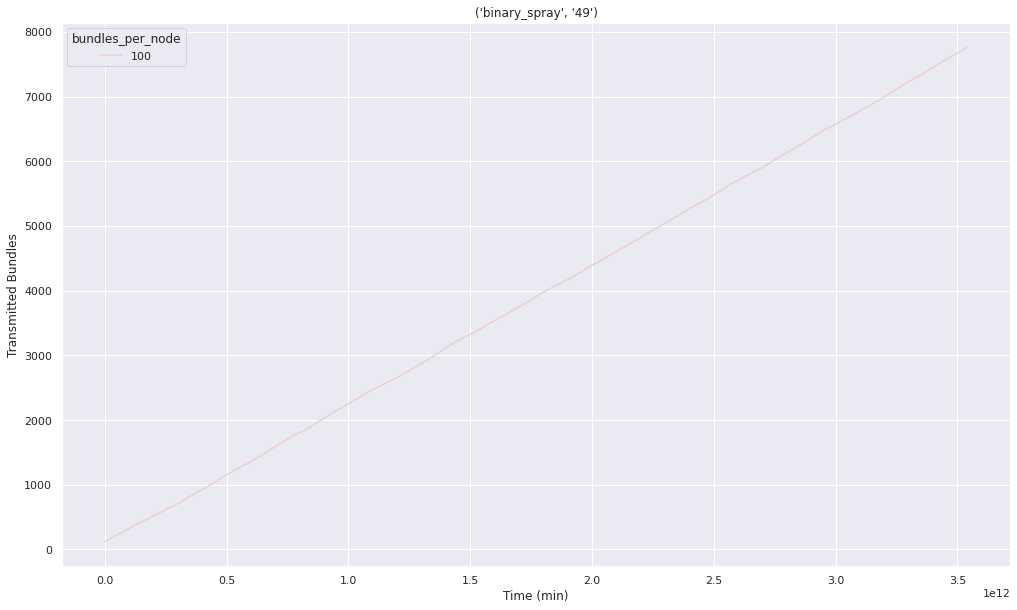

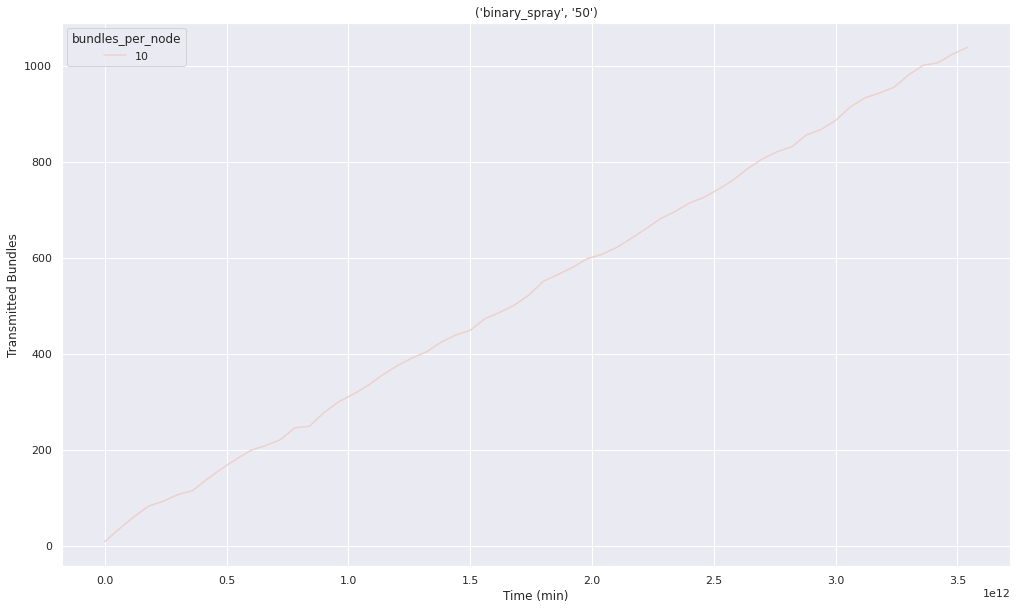

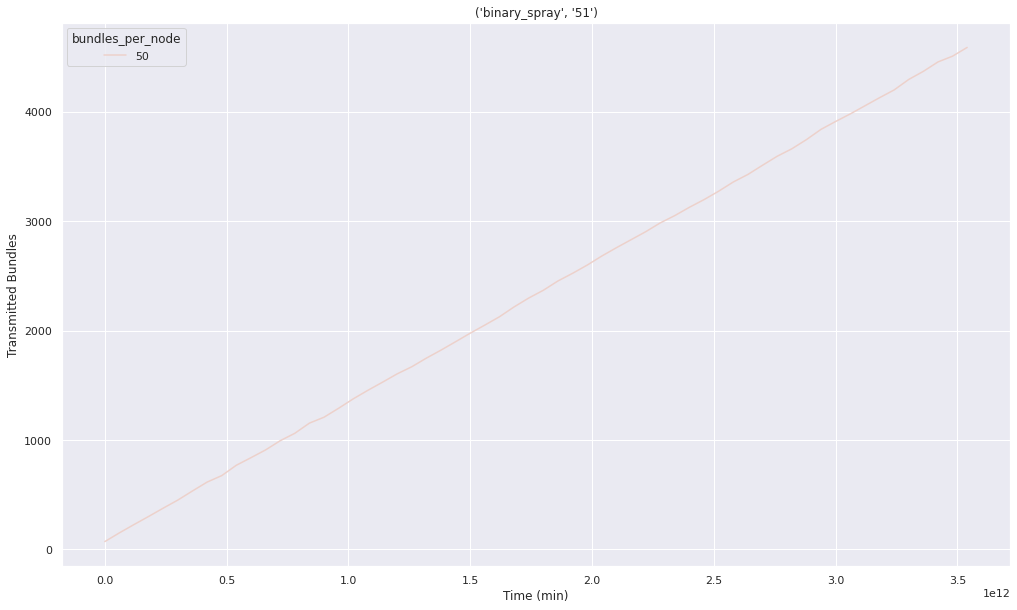

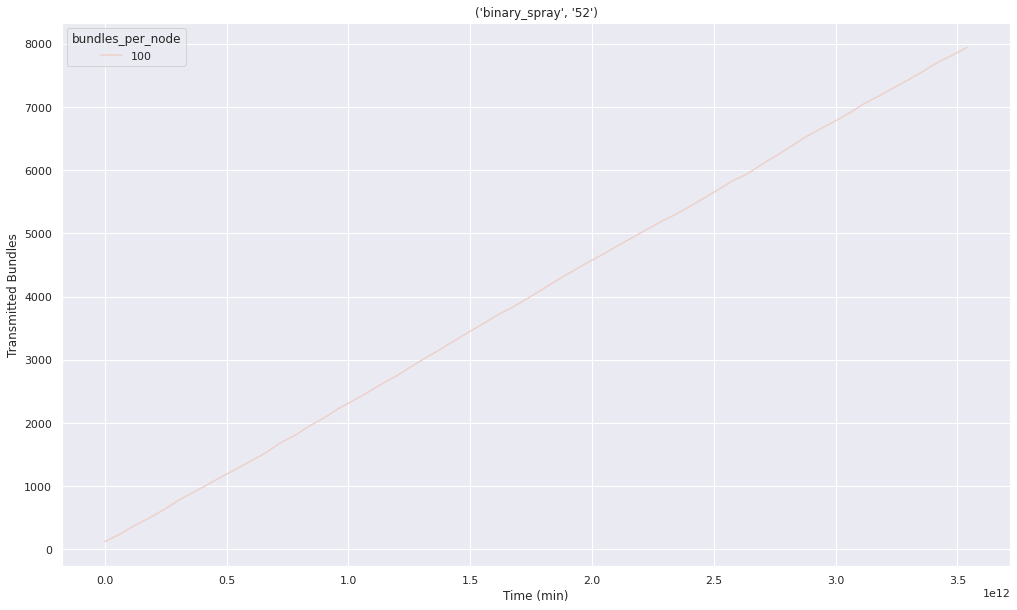

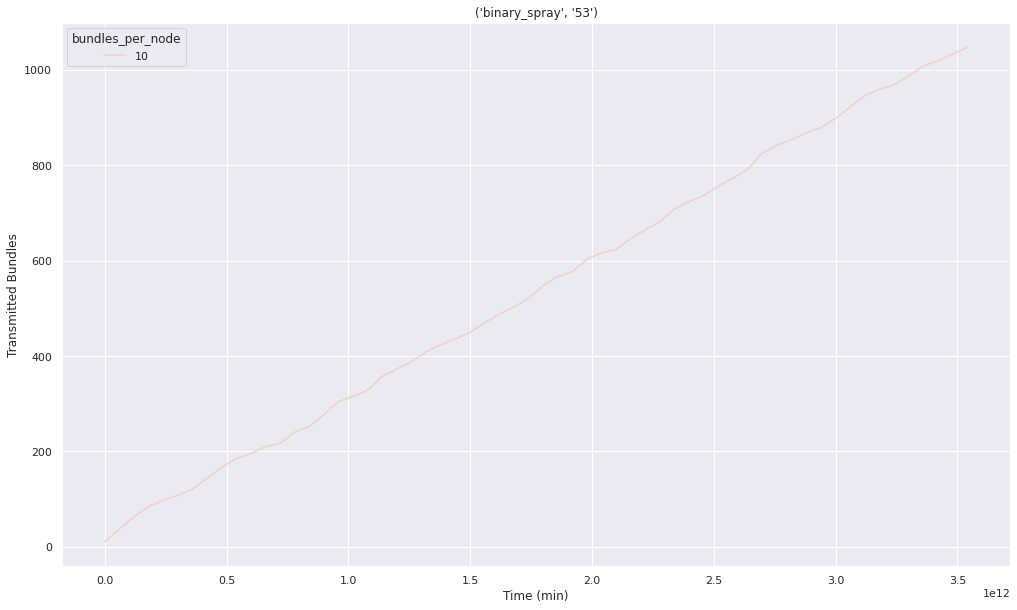

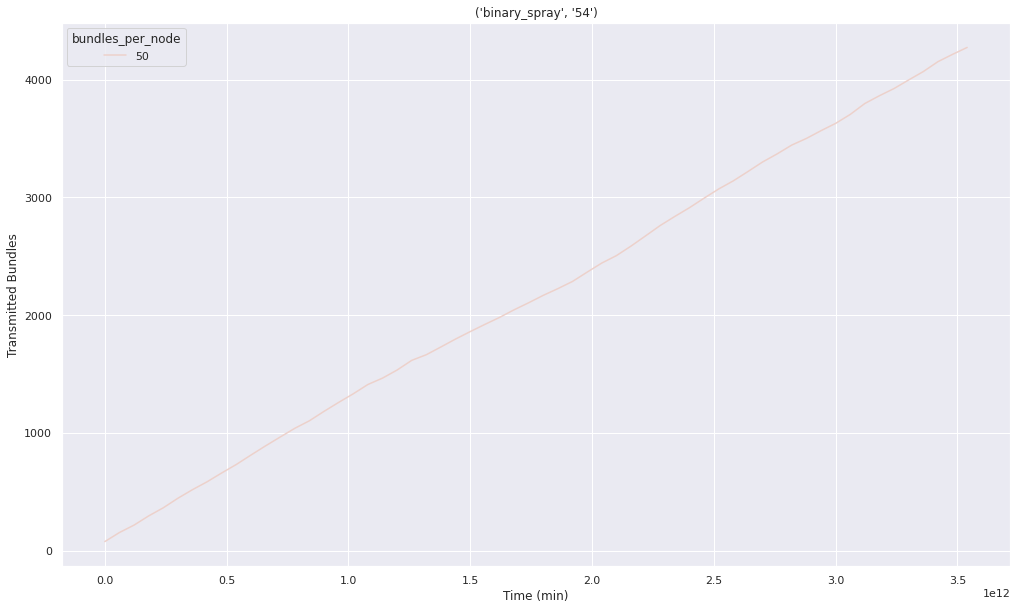

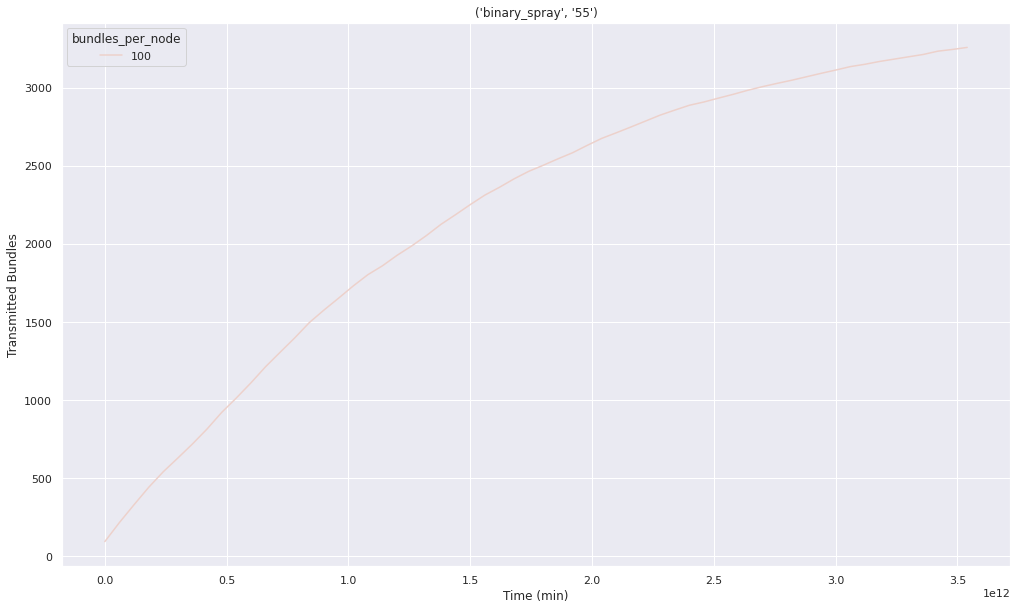

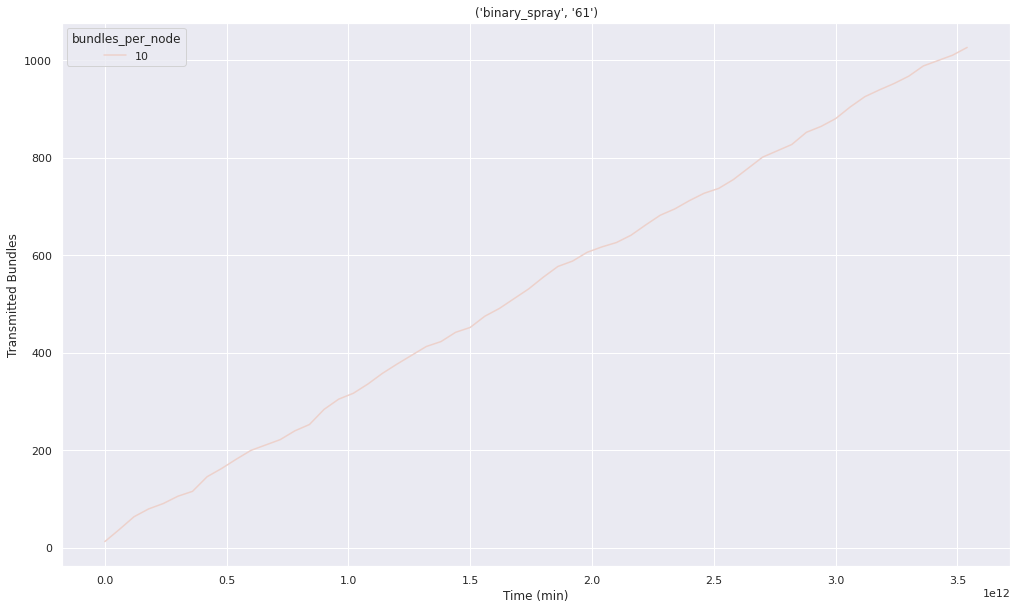

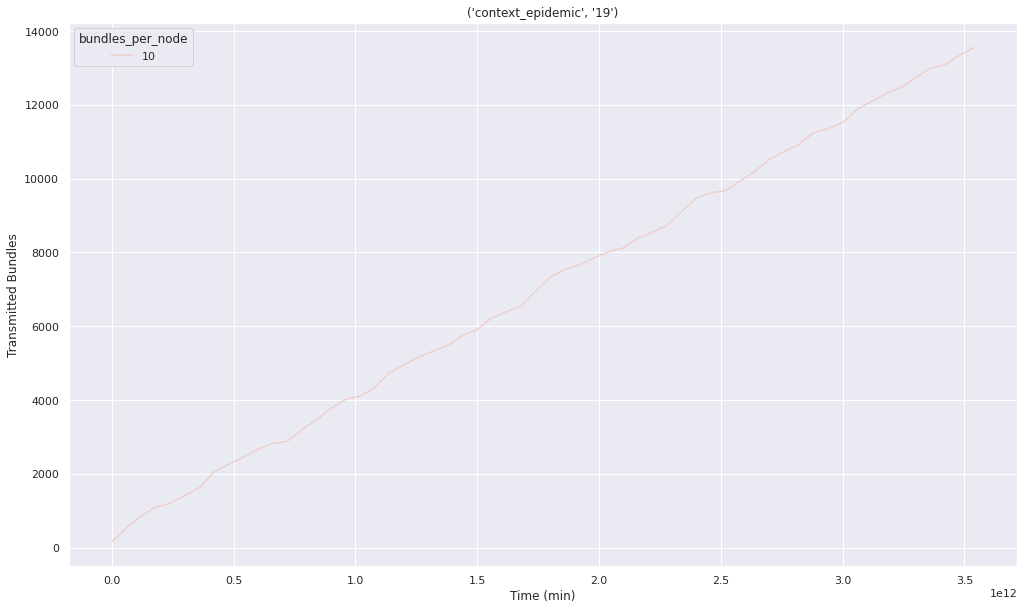

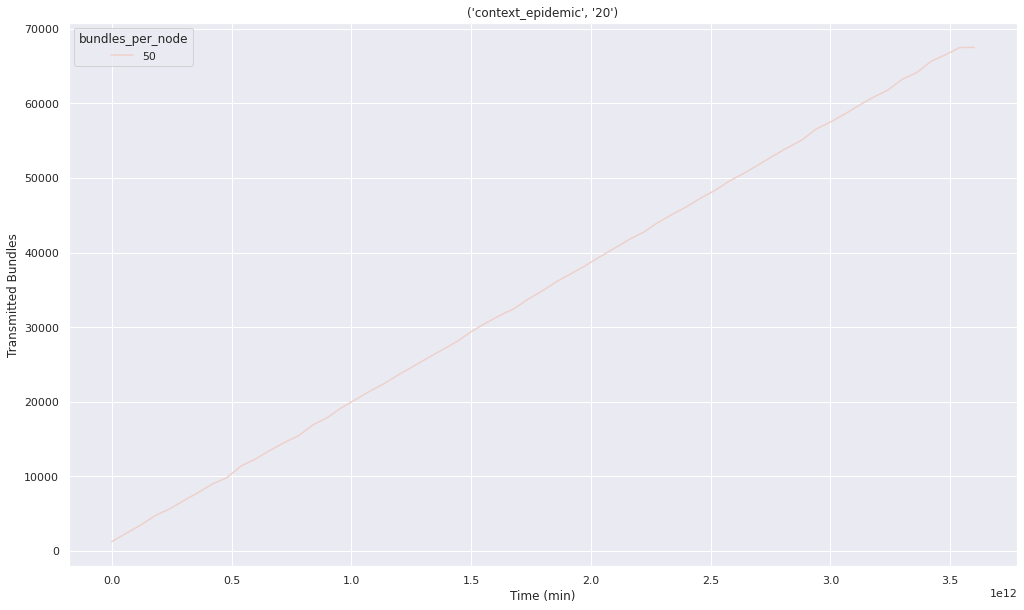

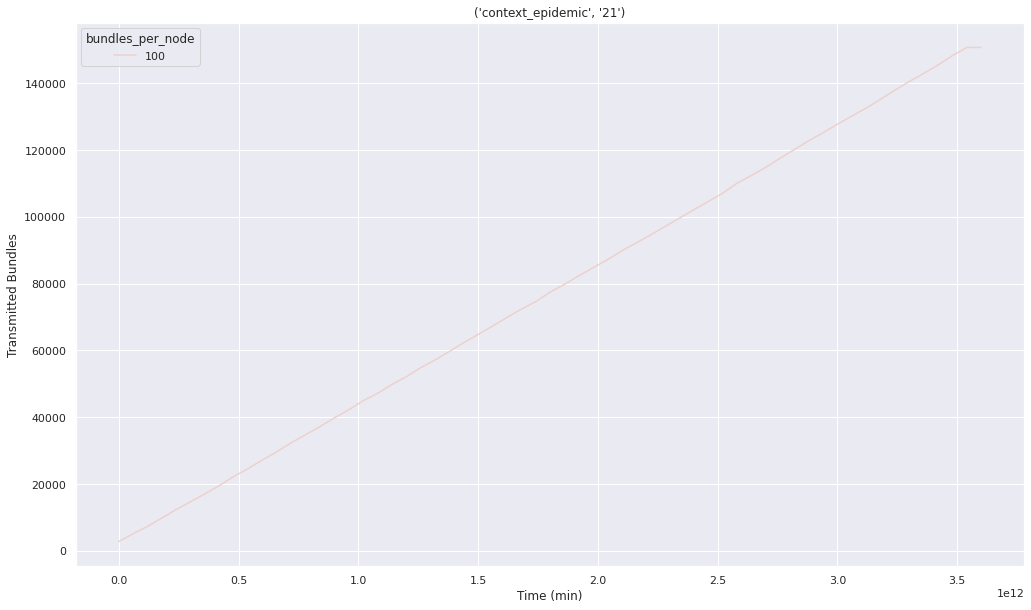

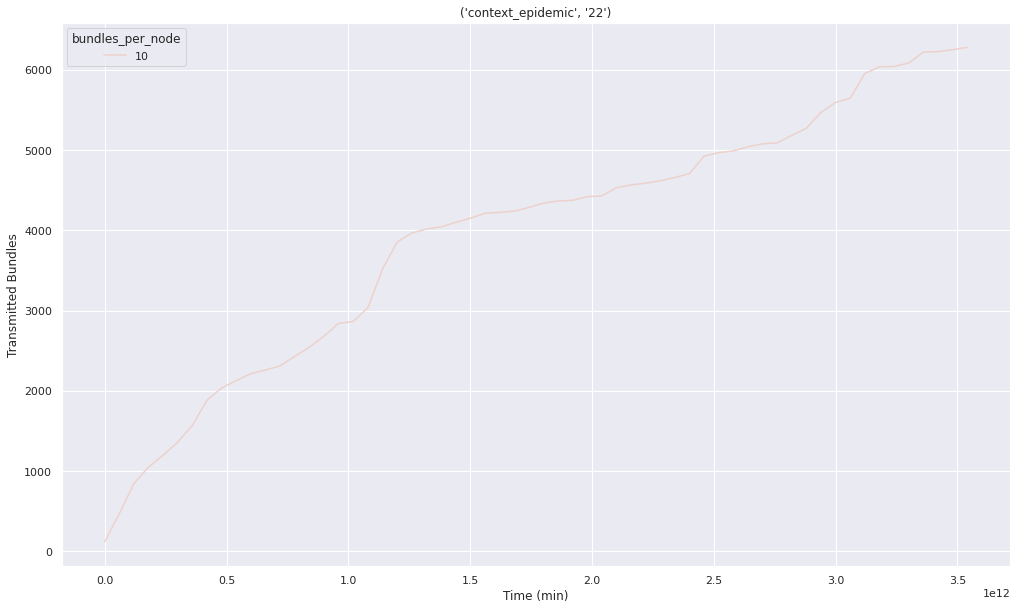

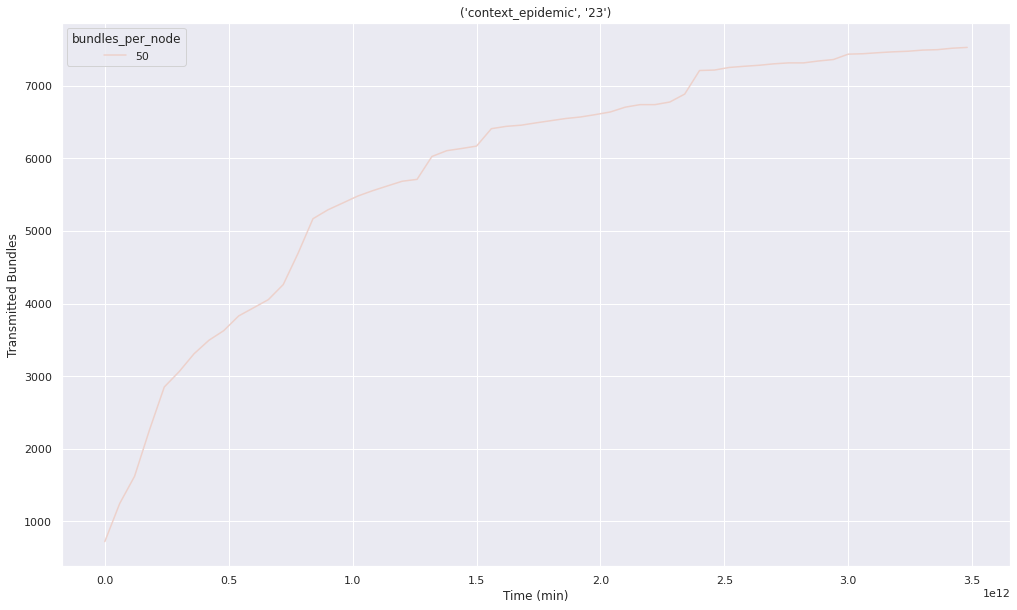

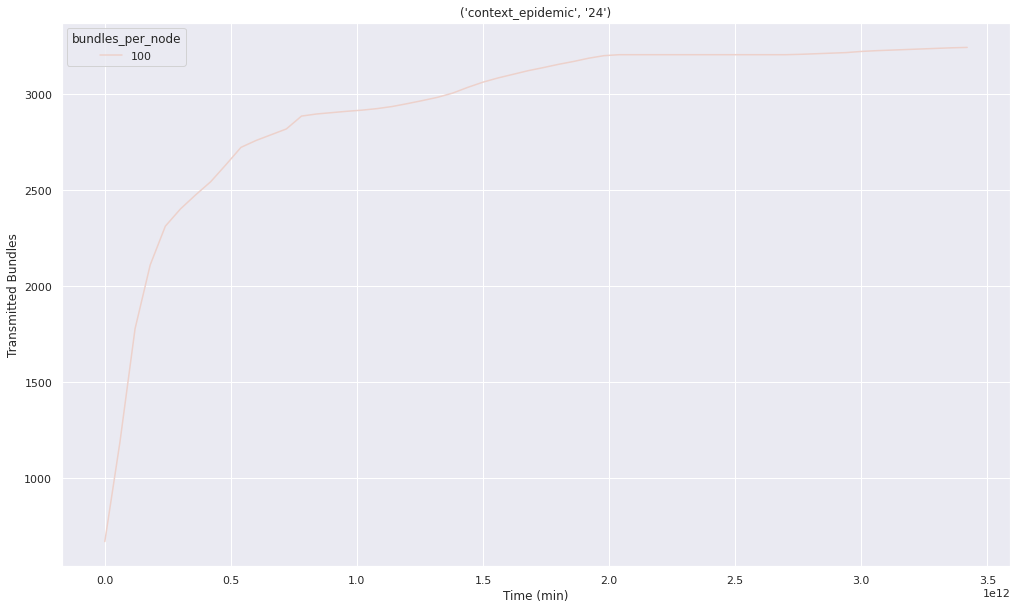

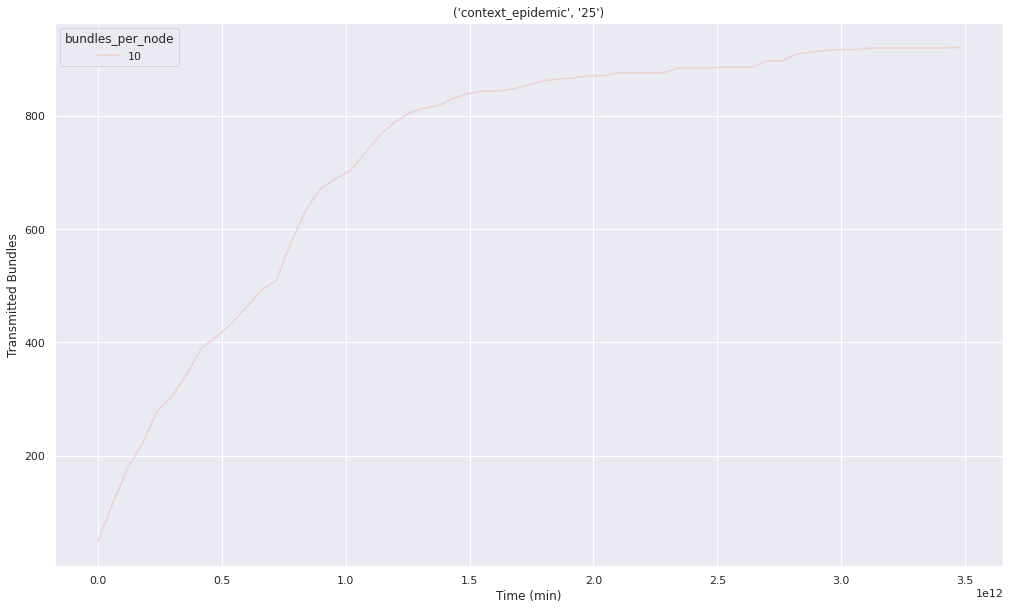

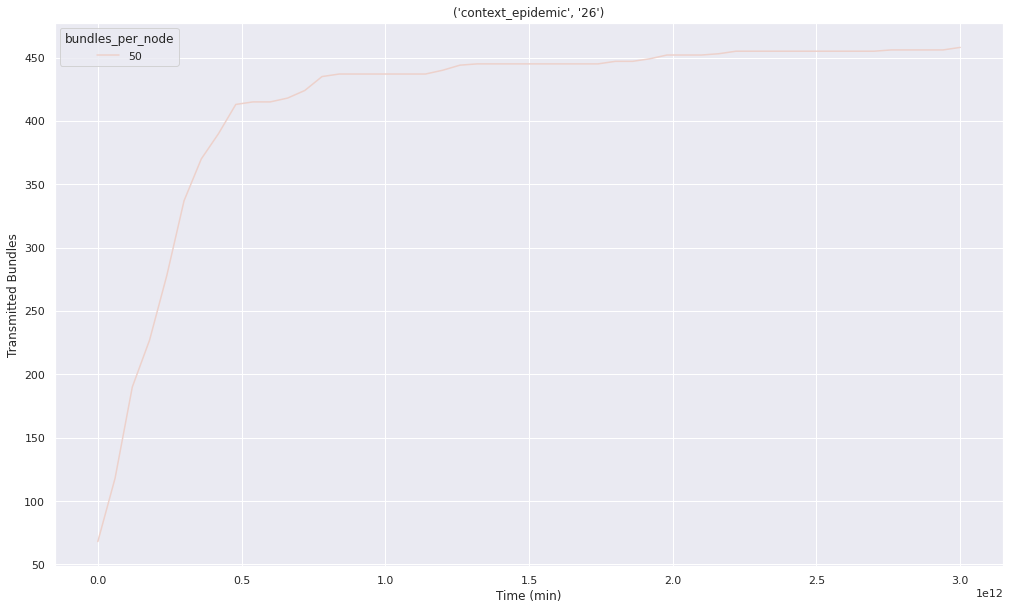

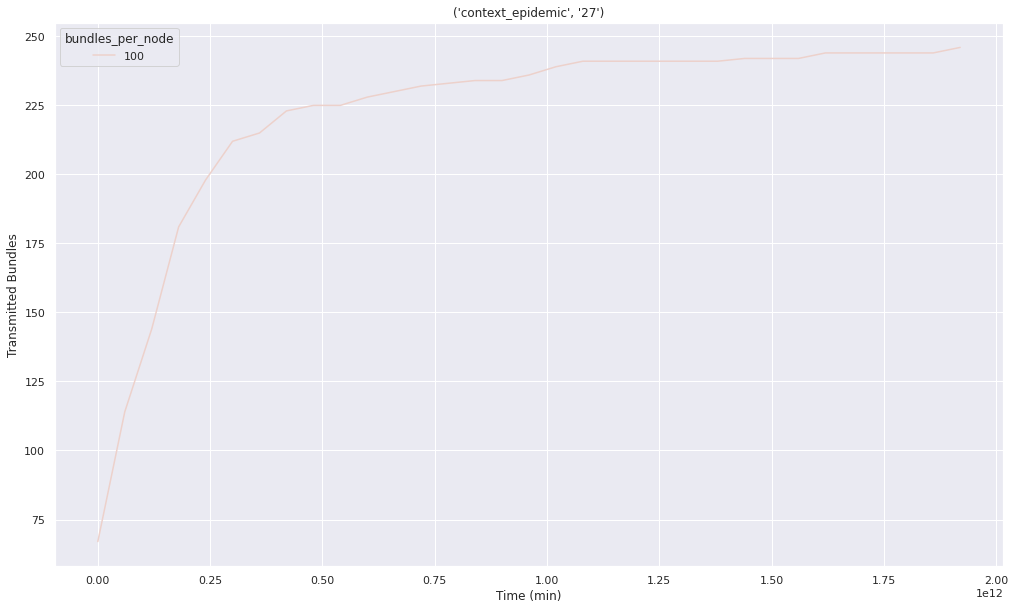

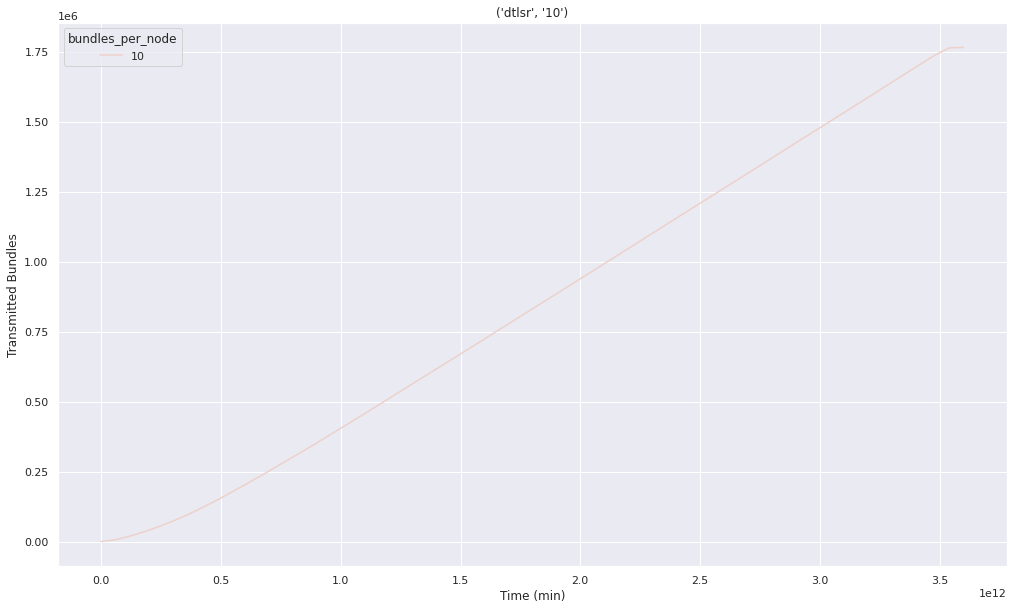

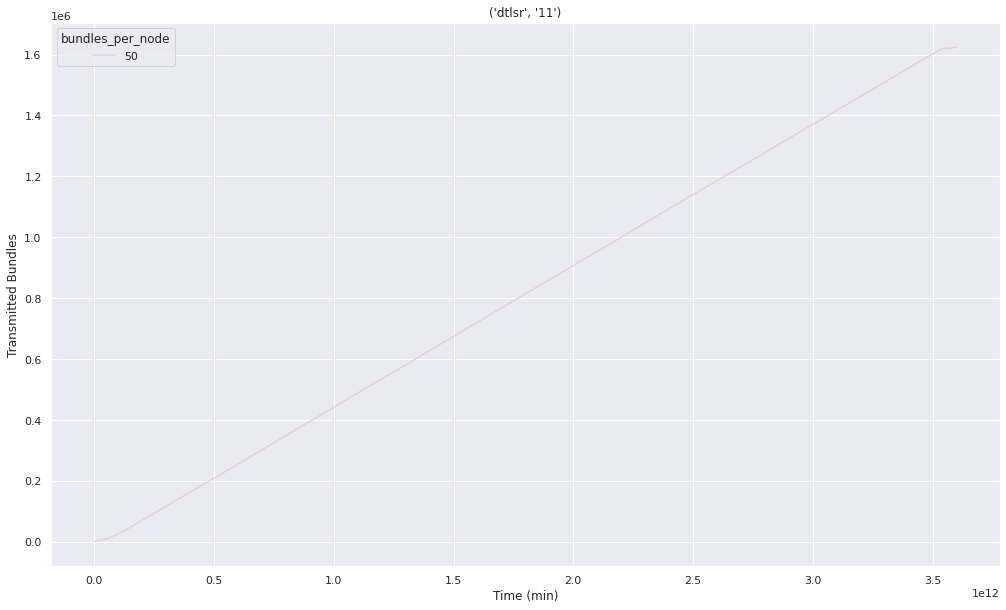

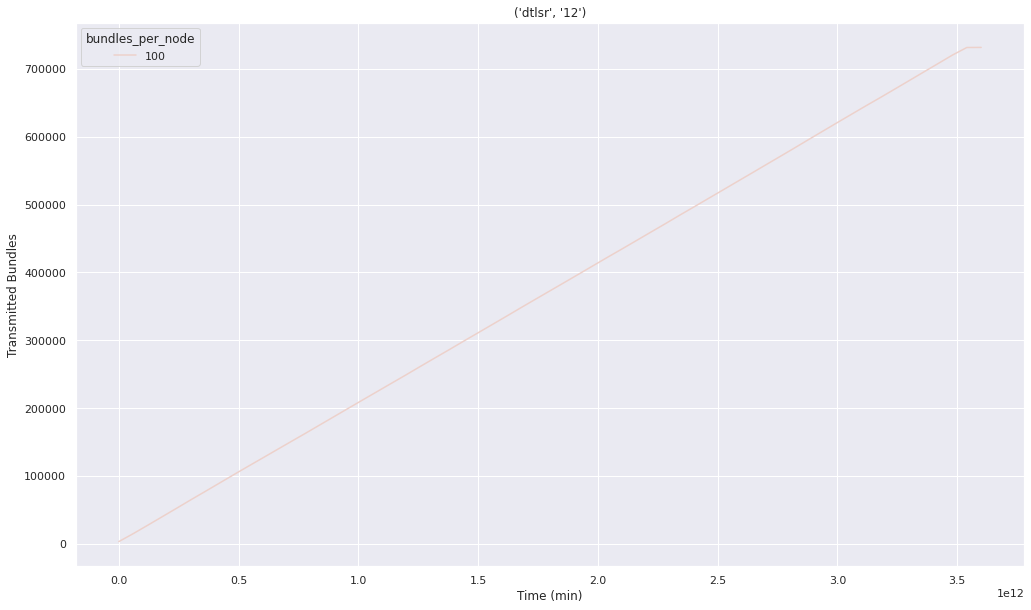

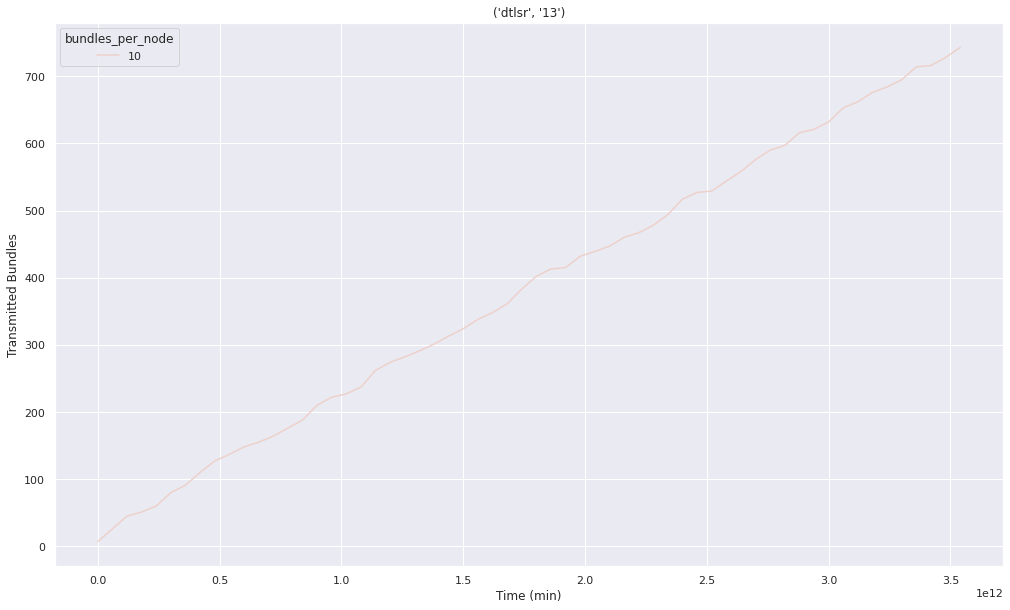

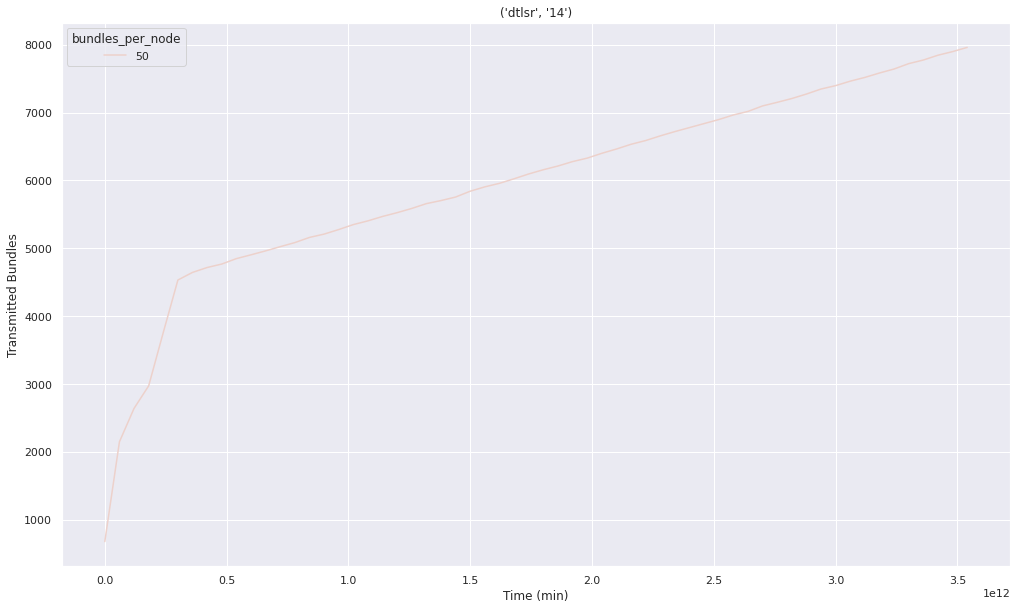

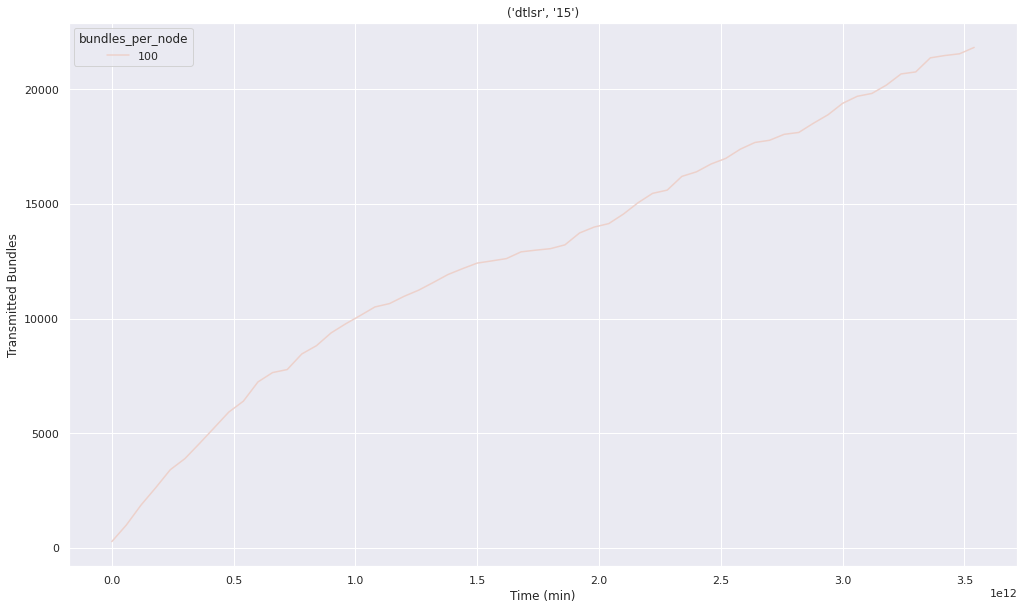

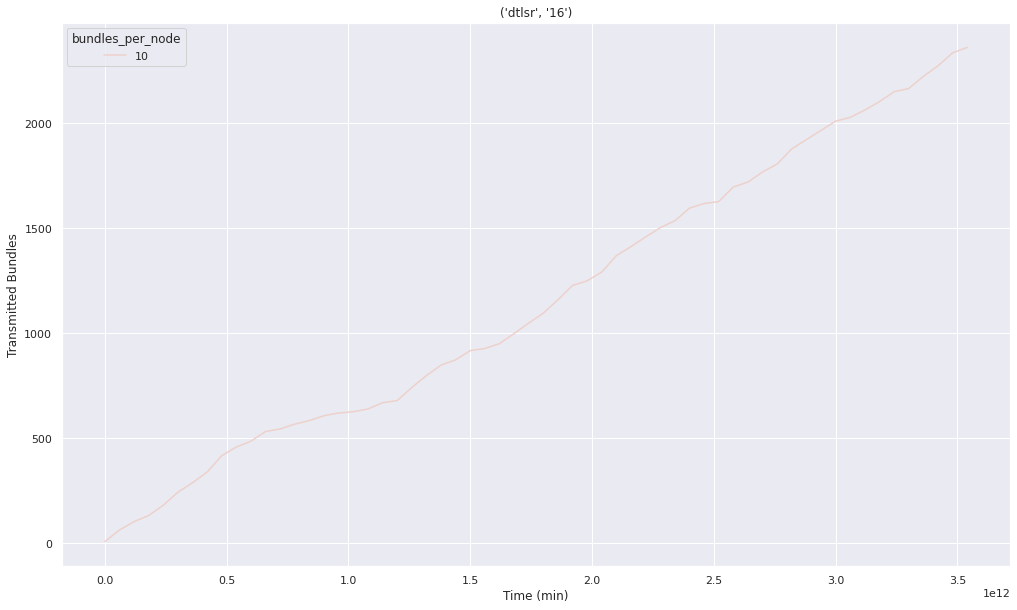

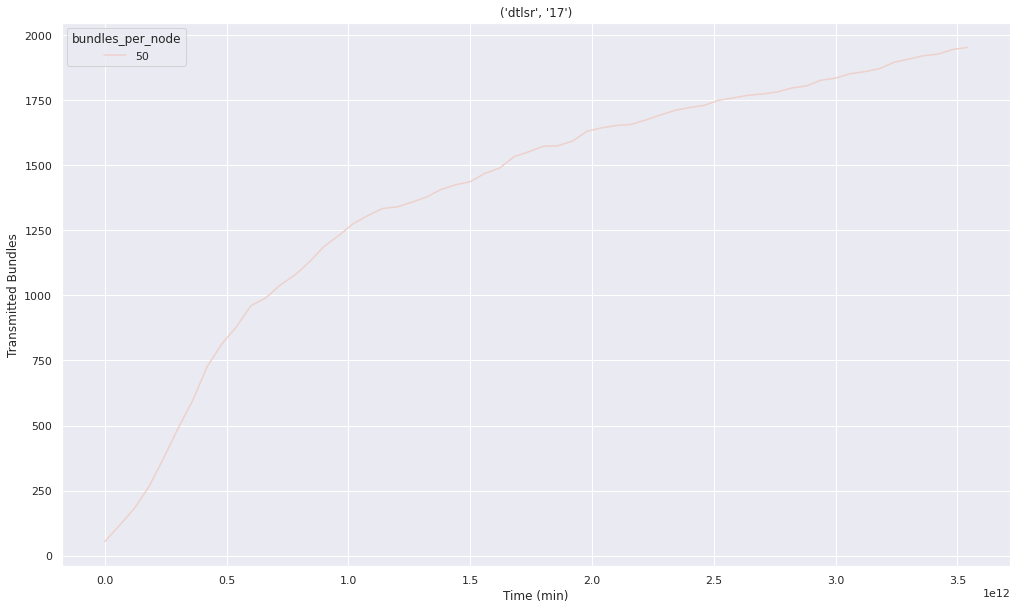

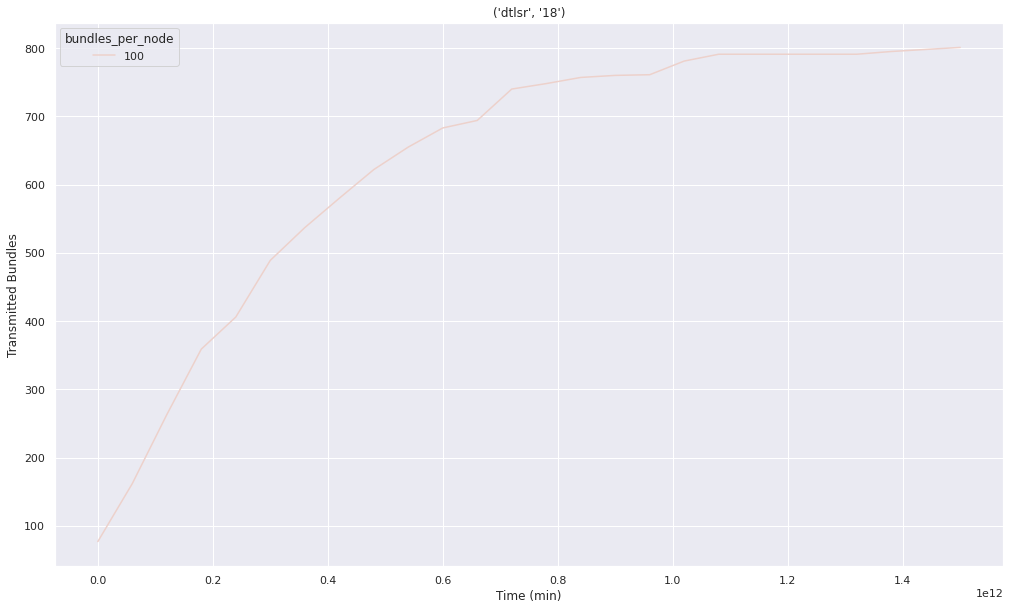

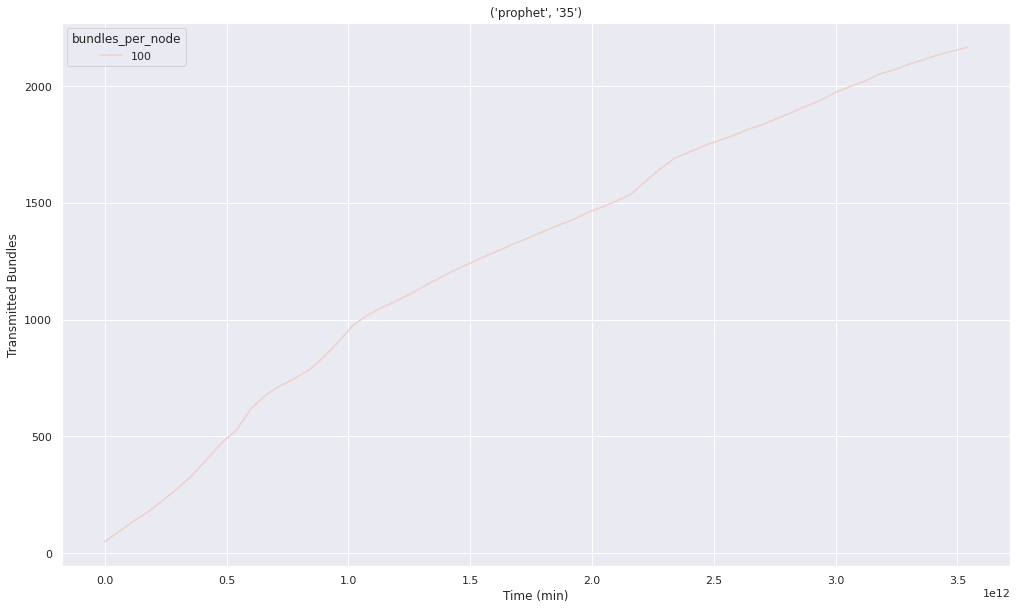

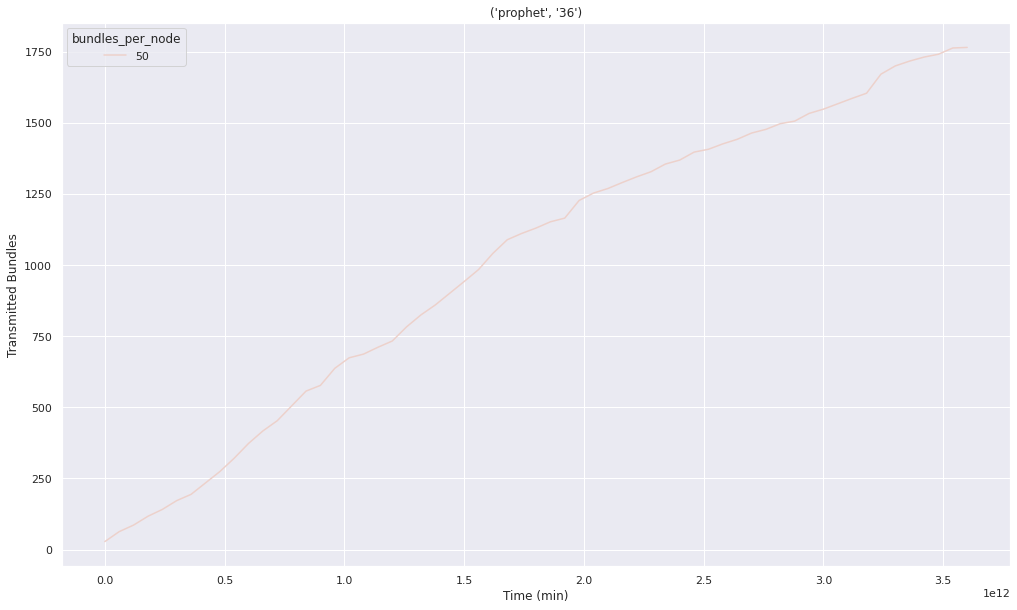

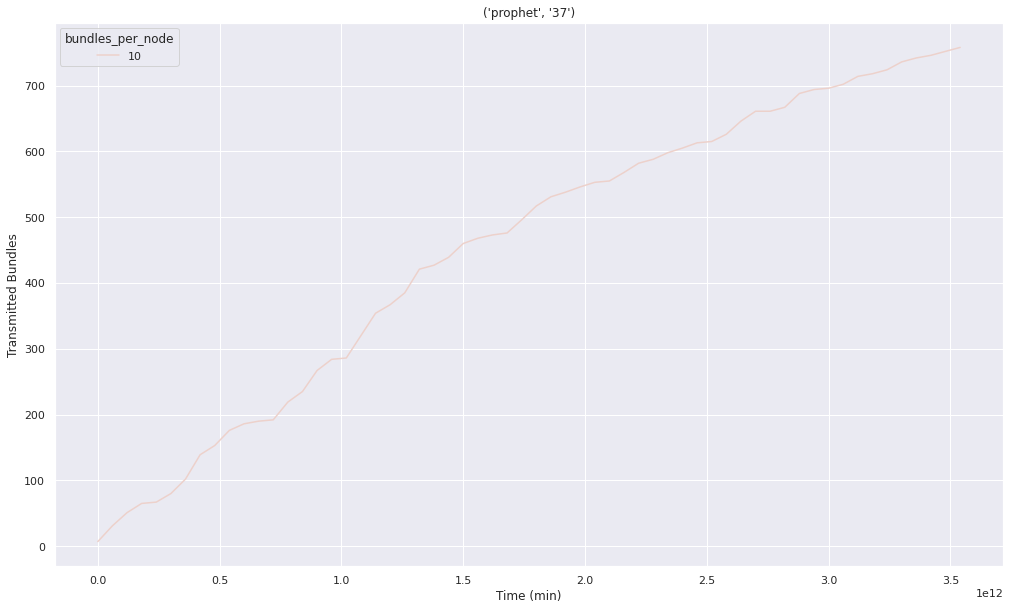

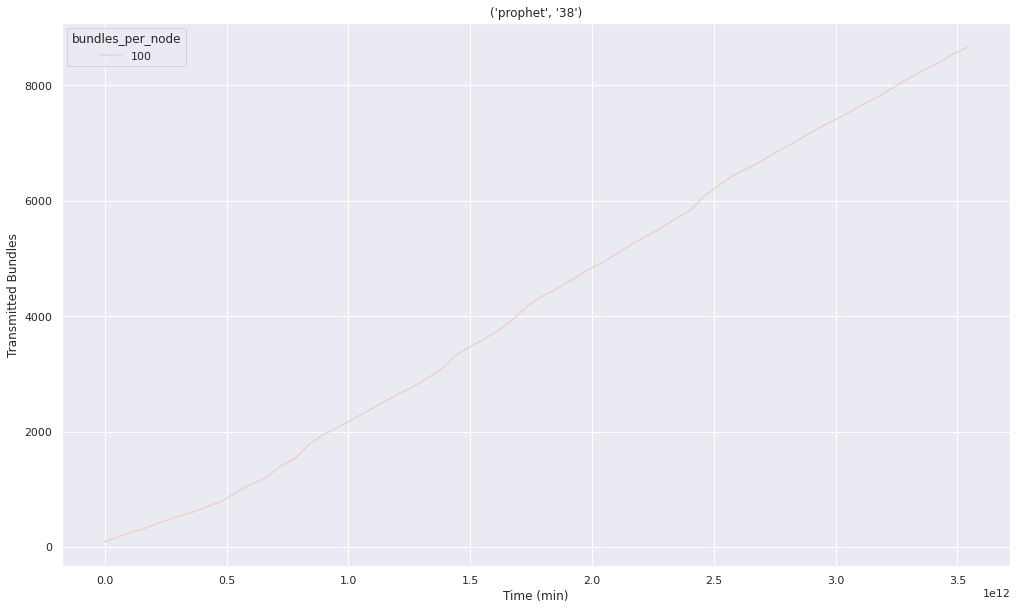

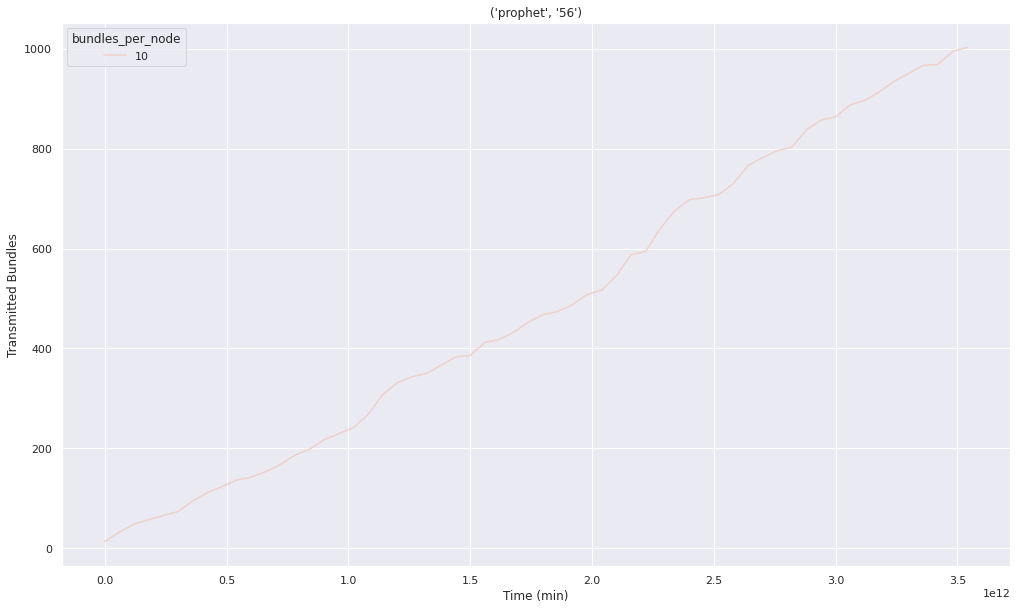

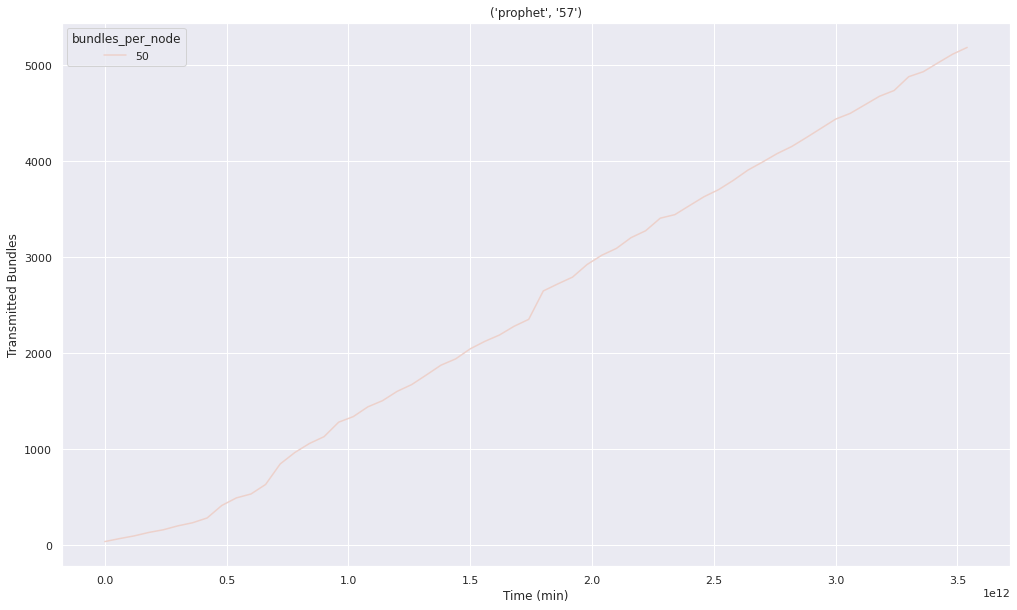

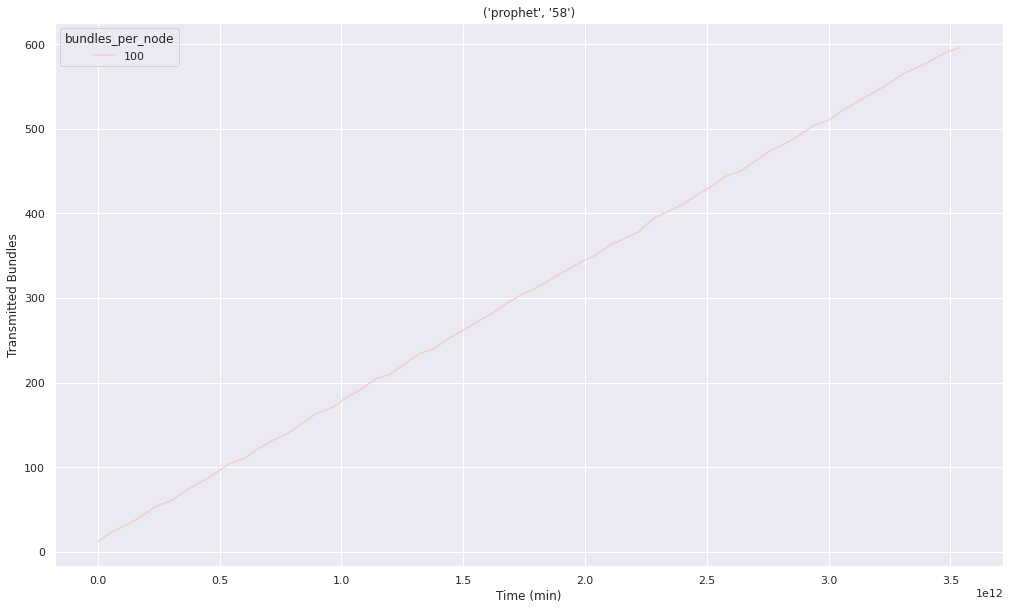

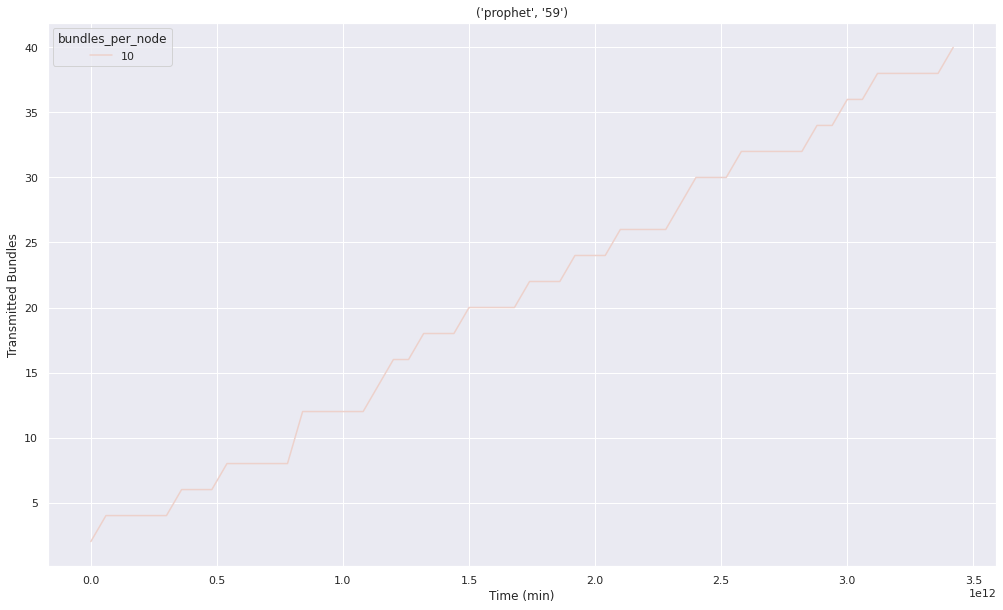

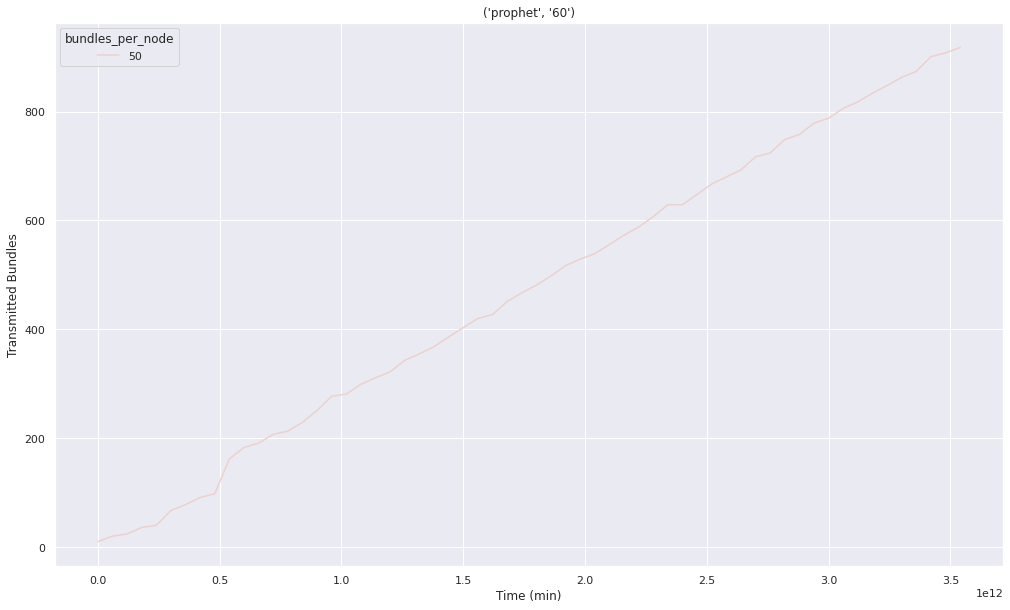

In [39]:
def plot_accumulated(big_fat_dataframe):
    for routing, instance_df in big_fat_dataframe.groupby(["routing", "sim_instance_id"]):
        fig, ax = plt.subplots(figsize=(17, 10))
        
        ax = sns.lineplot(
            x=instance_df.index,
            y='reception_accumulated',
            data=instance_df,
            hue="bundles_per_node",
            #palette=color_mapping,
            ax=ax
        )

        ax.set(xlabel='Time (min)', ylabel='Transmitted Bundles', title=routing)
    
    fig.savefig("/storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/evaluation/paper/figures/transmissions.pdf")

plot_accumulated(distribution_df)

# Compute and plot Average End-to-End Delay

In [13]:
def bundle_runtimes(event_frame: pd.DataFrame) -> DataFrame:
    simulation_data = event_frame #.set_index("timestamp")
    creation_instances = simulation_data[simulation_data.event == "creation"]
    
    delivery_instances = simulation_data[simulation_data.event == "delivery"].groupby(["sim_instance_id", "bundle"])
    
    big_fat_dataframe = pd.DataFrame()
    _len = len(delivery_instances)
    i = 0
    for name, instance in delivery_instances:
        if instance["meta"].any() == True:
            continue
        
        sim_instance_id, bundle = name
        
        instance = instance.sort_values("timestamp")
        delivery_row = instance.iloc[0]
        delivery_time = delivery_row["timestamp"]
        
        creation_row = creation_instances[creation_instances.bundle == bundle]
        if creation_row.empty:
            continue
        creation_time = creation_row["timestamp"].iloc[0]
        runtime = delivery_time - creation_time
        if runtime < pd.Timedelta(100,'ms'):
            continue
        
        runtime_dict = {
            "sim_instance_id": sim_instance_id,
            "bundle": bundle,
            "runtime": (runtime.to_pytimedelta() / timedelta(milliseconds=1)) / 1000,
            "routing": creation_row["routing"].values[0],
            "bundles_per_node": creation_row["bundles_per_node"].values[0],
            "payload_size": creation_row["payload_size"].values[0]
        }
        
        big_fat_dataframe = big_fat_dataframe.append(runtime_dict, ignore_index=True)
    
    return big_fat_dataframe

In [14]:
experiment_runtimes = bundle_runtimes(event_frame)

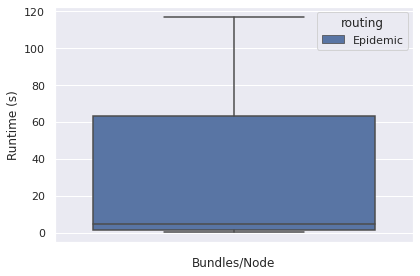

In [15]:
def plot_runtimes(df):
    ax = sns.boxplot(x="bundles_per_node", y="runtime", data=df, hue="routing")

    ax.set(xlabel="Bundles/Node" , ylabel='Runtime (s)')
    ax.set_xticklabels(
        ""
    )

    plt.tight_layout()
    plt.savefig("/home/jovyan/work/evaluation/paper/figures/runtimes.pdf")

plot_runtimes(experiment_runtimes)

# Compute and plot delivery ratio

In [16]:
def bundles_delivered(event_frame: pd.DataFrame) -> DataFrame:
    creation_instances = event_frame[event_frame.event == "creation"].groupby(["sim_instance_id"])
    
    delivery_instances = event_frame[event_frame.event == "delivery"]
    
    big_fat_dataframe = pd.DataFrame()
    for sim_instance_id, instance in creation_instances:
        for _, row in instance.iterrows():
            bundle = row["bundle"]
            
            if "dtn://coordinator/" in bundle:
                was_delivered = len(delivery_instances[delivery_instances["bundle"] == bundle]) >= 30
            else:
                was_delivered = not delivery_instances[delivery_instances["bundle"] == bundle].empty
                
            #if was_delivered:
            #    print(bundle, instance[instance["bundle"] == bundle]["timestamp"])
                
            row_dict = {
                "sim_instance_id": sim_instance_id,
                "bundle": bundle,
                "delivered": was_delivered,
                "routing": row["routing"],
                "payload_size": row["payload_size"],
                "bundles_per_node": row["bundles_per_node"],
            }
            big_fat_dataframe = big_fat_dataframe.append([row_dict], ignore_index=True)
            
    print(len(event_frame[event_frame.event == "creation"]), len(delivery_instances))
            
    return big_fat_dataframe   

In [17]:
def delivery_percentage(big_fat_dataframe) -> DataFrame:
    small_dataframe = pd.DataFrame()
    for name, bundles in big_fat_dataframe.groupby(["routing", "sim_instance_id"]):
        routing, sim_instance_id = name
        total_bundles = len(bundles.index)
        delivered_bundles = len(bundles[bundles.delivered == True].index)
        payload_size = bundles["payload_size"].values[0]
        bundles_per_node = bundles["bundles_per_node"].values[0]
        row_dict = {
            "routing": routing,
            "sim_instance_id": sim_instance_id,
            "delivery_percentage": (float(delivered_bundles) / float(total_bundles)) * 100,
            "payload_size": payload_size,
            "bundles_per_node": bundles_per_node,
        }
        small_dataframe = small_dataframe.append([row_dict], ignore_index=True)
    
    return small_dataframe

In [18]:
delivery_df = bundles_delivered(event_frame)
delivery_percentage_df = delivery_percentage(delivery_df)

260 1270


In [19]:
def plot_delivery_percentage(df):

    ax = sns.barplot(x="bundles_per_node", y="delivery_percentage", data=df, hue="routing")
    ax.set(xlabel="Bundles/Node" , ylabel='Delivery Ratio (%)', ylim=[0,100])
    ax.set_xticklabels(
        ""
    )

    plt.tight_layout()
    plt.savefig("/home/jovyan/work/evaluation/paper/figures/delivery-ratio.pdf")

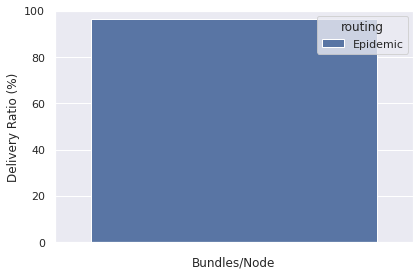

In [20]:
plot_delivery_percentage(delivery_percentage_df)